## This is the Capstone Project. 
## The code is about finding the most appropriate locality in the city of Toronto based on certain predefined needs. 

### We first import the necessary libraries required

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

### The list of postal codes is extracted from wikipedia. For the postal codes, which do not have sufficient information, the data is cleaned and adjusted. For example for Borogh values equal to 'Not Assigned', the record is not considered. 

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]
df_remove_na = df[df.Borough != 'Not assigned']
df_remove_na = df_remove_na.reset_index(drop=True)
df_assign_neighbour = df_remove_na
df_assign_neighbour.loc[(df_assign_neighbour.Neighbourhood == 'Not assigned'),'Neighbourhood'] = df_assign_neighbour.Borough
df_assign_neighbour.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


### The list of latitudes and longitudes is extracted from cocl.us website and the first five records of the data is displayed. 

In [3]:
df_lat_lon_data = pd.read_csv("http://cocl.us/Geospatial_data")
df_lat_lon_data.columns=['Postcode','Latitude','Longitude']
df_lat_lon_data.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### The dataframe of postal codes and its respective latitude and longitude postions are merged and first five records are listed

In [4]:
df_complete = pd.merge(df_assign_neighbour, df_lat_lon_data, on='Postcode', how='inner')
df_complete.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


### Since we are dealing with the city of Toronto only, we first get a list of unique values and then create 4 data frames for each area namely Central, East, West and DownTown Toronto

In [5]:

df_Toronto = df_complete[df_complete['Borough'].str.contains('Toronto')]
df_Toronto.Borough.unique()

df_E_Toronto = df_complete[df_complete['Borough'].str.contains('East Toronto')]
df_C_Toronto = df_complete[df_complete['Borough'].str.contains('Central Toronto')]
df_D_Toronto = df_complete[df_complete['Borough'].str.contains('Downtown Toronto')]
df_W_Toronto = df_complete[df_complete['Borough'].str.contains('West Toronto')]


### The client id, secret and version are defined to fetch data from foursquare.com

In [6]:
CLIENT_ID = '4YTPVVOGWFM5YMTDRXF3K2T02CHTVLQVLKCZJXOHK2Y2PI0E' # your Foursquare ID
CLIENT_SECRET = 'HWBBFRVWMYSSLDND4WIXXPQITS14GF3A5ZSI4IOE0TI4KBRN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: 4YTPVVOGWFM5YMTDRXF3K2T02CHTVLQVLKCZJXOHK2Y2PI0E
CLIENT_SECRET:HWBBFRVWMYSSLDND4WIXXPQITS14GF3A5ZSI4IOE0TI4KBRN


### The following is a function that converts a json file into a data frame. It takes an input variable of a json file and the output variable is a dataframe

In [7]:
# function that returns a data frame given a json file as an input. 
def convert_json_dataframe(results):
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues) # flatten JSON
        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues =nearby_venues.loc[:, filtered_columns]
        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        return nearby_venues

### The following is a function which extracts the category of a venue

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### In the following code, for a radius of 500 meters and a limit of 100 entries, for each Neighbourhood in East Toronto, the list of venues is extracted from foursquare.com and a dataframe is generated from all these venues by calling the convert_json_dataframe function. Also the first 5 records of the dataframe are listed

In [15]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
radius = 500 # define radius
East_Toronto_venues = pd.DataFrame(columns=None)
East_Toronto_temp = pd.DataFrame(columns=None)
for lat, lng, borough, neighborhood in zip(df_E_Toronto['Latitude'], df_E_Toronto['Longitude'], df_E_Toronto['Borough'], df_E_Toronto['Neighbourhood']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    East_Toronto_temp = convert_json_dataframe(results)
    East_Toronto_venues = East_Toronto_venues.append(East_Toronto_temp)
East_Toronto_venues.head()


,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,Glen Stewart Ravine,Other Great Outdoors,43.676300,-79.294784
2,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
3,Grover Pub and Grub,Pub,43.679181,-79.297215
4,Upper Beaches,Neighborhood,43.680563,-79.292869


### In the following code, for a radius of 500 meters and a limit of 100 entries, for each Neighbourhood in West Toronto, the list of venues is extracted from foursquare.com and a dataframe is generated from all these venues by calling the convert_json_dataframe function. Also the first 5 records of the dataframe are listed

In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
radius = 500 # define radius
West_Toronto_venues = pd.DataFrame(columns=None)
West_Toronto_temp = pd.DataFrame(columns=None)
for lat, lng, borough, neighborhood in zip(df_W_Toronto['Latitude'], df_W_Toronto['Longitude'], df_W_Toronto['Borough'], df_W_Toronto['Neighbourhood']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    West_Toronto_temp = convert_json_dataframe(results)
    West_Toronto_venues = West_Toronto_venues.append(West_Toronto_temp)
West_Toronto_venues.head()


,name,categories,lat,lng
0,The Greater Good Bar,Bar,43.669409,-79.439267
1,Parallel,Middle Eastern Restaurant,43.669516,-79.438728
2,Planet Fitness,Gym / Fitness Center,43.667588,-79.442574
3,Blood Brothers Brewing,Brewery,43.669944,-79.436533
4,FreshCo,Grocery Store,43.667918,-79.440754


### In the following code, for a radius of 500 meters and a limit of 100 entries, for each Neighbourhood in DownTown Toronto, the list of venues is extracted from foursquare.com and a dataframe is generated from all these venues by calling the convert_json_dataframe function. Also the first 5 records of the dataframe are listed

In [17]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
DT_Toronto_venues = pd.DataFrame(columns=None)
DT_Toronto_temp = pd.DataFrame(columns=None)
for lat, lng, borough, neighborhood in zip(df_D_Toronto['Latitude'], df_D_Toronto['Longitude'], df_D_Toronto['Borough'], df_D_Toronto['Neighbourhood']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    DT_Toronto_temp = convert_json_dataframe(results)
    DT_Toronto_venues = DT_Toronto_venues.append(DT_Toronto_temp)
DT_Toronto_venues.head()


,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Gym / Fitness Center,43.653191,-79.357947
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149


### In the following code, for a radius of 500 meters and a limit of 100 entries, for each Neighbourhood in Central Toronto, the list of venues is extracted from foursquare.com and a dataframe is generated from all these venues by calling the convert_json_dataframe function. Also the first 5 records of the dataframe are listed

In [18]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
Central_Toronto_venues = pd.DataFrame(columns=None)
Central_Toronto_temp = pd.DataFrame(columns=None)
for lat, lng, borough, neighborhood in zip(df_C_Toronto['Latitude'], df_C_Toronto['Longitude'], df_C_Toronto['Borough'], df_C_Toronto['Neighbourhood']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
    results = requests.get(url).json()
    Central_Toronto_temp = convert_json_dataframe(results)
    Central_Toronto_venues = Central_Toronto_venues.append(Central_Toronto_temp)
Central_Toronto_venues.head()


,name,categories,lat,lng
0,Lawrence Park Ravine,Park,43.726963,-79.394382
1,The Photo School – Toronto,Photography Studio,43.730429,-79.388767
2,Averax Group,Construction & Landscaping,43.727406,-79.383103
3,Zodiac Swim School,Swim School,43.728532,-79.382860
4,TTC Bus #162 - Lawrence-Donway,Bus Line,43.728026,-79.382805


### Based on our problem statment and the category of venues, we fix a set of preferences that we are interested in. 

In [19]:
preferences = ['Asian Restaurant','Vegetarian / Vegan Restaurant','Health Food Store','Yoga Studio','Bookstore','Park','Grocery Store','Movie Theater','Café','Gym / Fitness Center','Light Rail Station']

### In the following code, based on the list of preferences, we generated a data frame for each region with only those categories which fit our criteria

In [20]:
East_Toronto_pref = East_Toronto_venues[East_Toronto_venues.categories.isin(preferences)]
East_Toronto_pref = East_Toronto_pref.reset_index(drop=True)
West_Toronto_pref = West_Toronto_venues[West_Toronto_venues.categories.isin(preferences)]
West_Toronto_pref = West_Toronto_pref.reset_index(drop=True)
DT_Toronto_pref = DT_Toronto_venues[DT_Toronto_venues.categories.isin(preferences)]
DT_Toronto_pref = DT_Toronto_pref.reset_index(drop=True)
Central_Toronto_pref = Central_Toronto_venues[Central_Toronto_venues.categories.isin(preferences)]
Central_Toronto_pref =Central_Toronto_pref.reset_index(drop=True)


### For East Toronto, we get a count of venues for each of our preferred categories

In [21]:
East_Tor_group = East_Toronto_pref.groupby(['categories'],as_index=False).count().iloc[:,[0,1]]
East_Tor_group

,categories,name
0,Bookstore,5
1,Café,6
2,Grocery Store,2
3,Gym / Fitness Center,1
4,Health Food Store,1
5,Light Rail Station,1
6,Movie Theater,2
7,Park,4
8,Yoga Studio,3


### For West Toronto, we get a count of venues for each of our preferred categories

In [22]:
West_Tor_group = West_Toronto_pref.groupby(['categories'],as_index=False).count().iloc[:,[0,1]]
West_Tor_group

,categories,name
0,Asian Restaurant,6
1,Bookstore,6
2,Café,25
3,Grocery Store,7
4,Gym / Fitness Center,2
5,Health Food Store,2
6,Movie Theater,2
7,Park,6
8,Vegetarian / Vegan Restaurant,4
9,Yoga Studio,4


### For Down Town Toronto, we get a count of venues for each of our preferred categories

In [23]:
DT_Tor_group = DT_Toronto_pref.groupby(['categories'],as_index=False).count().iloc[:,[0,1]]
DT_Tor_group

,categories,name
0,Asian Restaurant,16
1,Bookstore,24
2,Café,127
3,Grocery Store,14
4,Gym / Fitness Center,14
5,Health Food Store,1
6,Movie Theater,4
7,Park,36
8,Vegetarian / Vegan Restaurant,31
9,Yoga Studio,5


### For Central Toronto, we get a count of venues for each of our preferred categories

In [24]:
Central_Tor_group = Central_Toronto_pref.groupby(['categories'],as_index=False).count().iloc[:,[0,1]]
Central_Tor_group

,categories,name
0,Café,12
1,Gym / Fitness Center,1
2,Light Rail Station,5
3,Park,9
4,Vegetarian / Vegan Restaurant,3
5,Yoga Studio,1


### Finally, we create a dataframe which lists all our ten preferences and the count of venues for  each preference in each area. 

In [25]:
final_grouped_df = pd.DataFrame(columns=['Categories','East Toronto','West Toronto','DownTown Toronto','Central Toronto'])
final_grouped_df = pd.merge(East_Tor_group, West_Tor_group, on='categories', how='outer') 
final_grouped_df = pd.merge(final_grouped_df, DT_Tor_group, on='categories', how='outer') 
final_grouped_df = pd.merge(final_grouped_df, Central_Tor_group, on='categories', how='outer') 
final_grouped_df.replace(np.nan,0, inplace=True)
final_grouped_df.columns=['Categories','East Toronto','West Toronto','DownTown Toronto','Central Toronto']
final_grouped_df

,Categories,East Toronto,West Toronto,DownTown Toronto,Central Toronto
0,Bookstore,5.0,6.0,24.0,0.0
1,Café,6.0,25.0,127.0,12.0
2,Grocery Store,2.0,7.0,14.0,0.0
3,Gym / Fitness Center,1.0,2.0,14.0,1.0
4,Health Food Store,1.0,2.0,1.0,0.0
5,Light Rail Station,1.0,0.0,0.0,5.0
6,Movie Theater,2.0,2.0,4.0,0.0
7,Park,4.0,6.0,36.0,9.0
8,Yoga Studio,3.0,4.0,5.0,1.0
9,Asian Restaurant,0.0,6.0,16.0,0.0


### We create a bar chart for each of the areas and come up with the conclusion that DownTown Toronto best meets the requirements

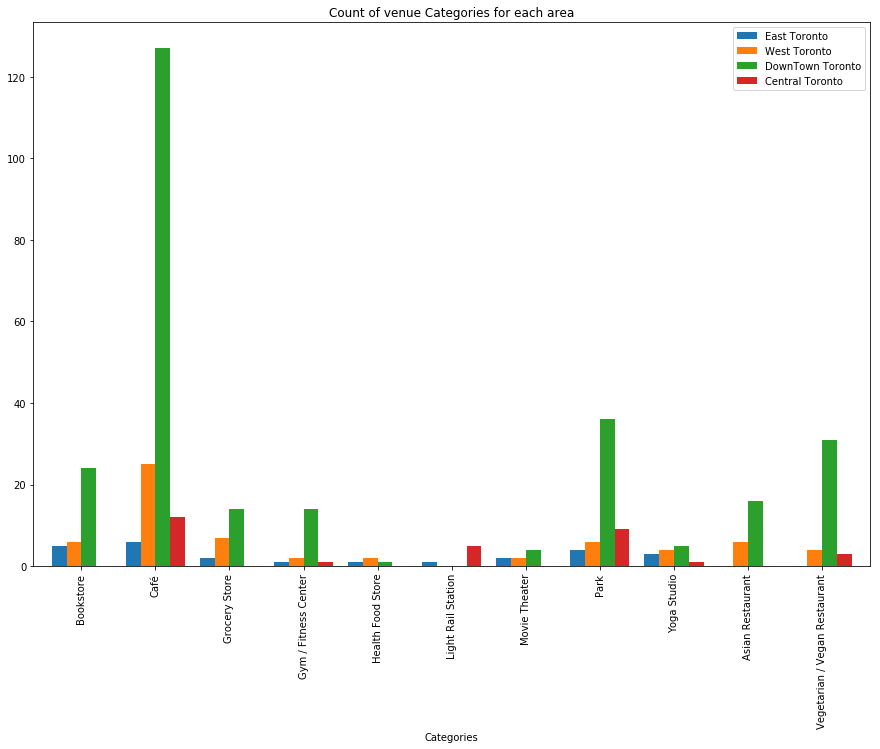

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
final_grouped_df.plot(kind='bar', stacked=False, width=0.8,figsize=(15,10),x='Categories',grid=False, title='Count of venue Categories for each area')


### Now that we know DownTown Toronto is our area of choice, we explore it further for a detailed analysis. First we plot a graph of the locality for each Neighbourhood 

In [27]:
address = 'DownTown Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Central Toronto are {}, {}.'.format(latitude, longitude))
# create map of Toronto using latitude and longitude values
map_dttoronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_D_Toronto['Latitude'], df_D_Toronto['Longitude'], df_D_Toronto['Borough'], df_D_Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dttoronto)  
    
map_dttoronto 


The geograpical coordinate of Central Toronto are 43.6563221, -79.3809161.


### The following function given parameters of a list of Neighbourhoods, latitudes and longitudes gives us the list of venues at a redius of 500 meters. 

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

### For the list of Neighbourhood values of DownTown Toronto, we will get the values of all venues by calling the function getNearbyVenues

In [29]:
DT_Toronto_venues = getNearbyVenues(names=df_D_Toronto['Neighbourhood'],
                                   latitudes=df_D_Toronto['Latitude'],
                                   longitudes=df_D_Toronto['Longitude']
                                  )

### From the list of venues of DownTown Toronto, we filter the ones of our choice as per the preferences list ( according to problem statement ) 

In [30]:
DT_Toronto_pref_ven = DT_Toronto_venues[DT_Toronto_venues.Category.isin(preferences)]
DT_Toronto_pref_ven.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
Neighbourhood,,,,,,
Adelaide,11,11,11,11,11,11
Berczy Park,4,4,4,4,4,4
Cabbagetown,7,7,7,7,7,7
Central Bay Street,8,8,8,8,8,8
Chinatown,12,12,12,12,12,12
Christie,9,9,9,9,9,9
Church and Wellesley,6,6,6,6,6,6
Commerce Court,13,13,13,13,13,13
Design Exchange,11,11,11,11,11,11


### The following code does oneHotEncoding to make the readings in a scale from 0 to 1 and prints the first 5 rows of the resultant dataframe

In [31]:
# one hot encoding
dt_Toronto_onehot = pd.get_dummies(DT_Toronto_pref_ven[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dt_Toronto_onehot['Neighbourhood'] = DT_Toronto_pref_ven['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [dt_Toronto_onehot.columns[-1]] + list(dt_Toronto_onehot.columns[:-1])
dt_Toronto_onehot = dt_Toronto_onehot[fixed_columns]
dt_Toronto_onehot.head()

,Neighbourhood,Asian Restaurant,Bookstore,Café,Grocery Store,Gym / Fitness Center,Health Food Store,Movie Theater,Park,Vegetarian / Vegan Restaurant,Yoga Studio
2,Harbourfront,0,0,0,0,1,0,0,0,0,0
7,Harbourfront,0,0,0,0,0,0,0,1,0,0
19,Harbourfront,0,0,0,0,0,0,0,1,0,0
21,Harbourfront,0,0,1,0,0,0,0,0,0,0
25,Harbourfront,0,0,0,0,0,0,0,1,0,0


### In the following code, we group the scaled data by Neighbourhood values, calculate the mean and reset the index of the dataframe. We also display the first 5 rows

In [32]:
dt_Toronto_grouped =dt_Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
dt_Toronto_grouped.head()

,Neighbourhood,Asian Restaurant,Bookstore,Café,Grocery Store,Gym / Fitness Center,Health Food Store,Movie Theater,Park,Vegetarian / Vegan Restaurant,Yoga Studio
0,Adelaide,0.181818,0.181818,0.363636,0.000000,0.090909,0.0,0.0,0.000000,0.181818,0.000
1,Berczy Park,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.0,0.250000,0.250000,0.000
2,Cabbagetown,0.000000,0.000000,0.428571,0.142857,0.000000,0.0,0.0,0.428571,0.000000,0.000
3,Central Bay Street,0.000000,0.125000,0.250000,0.000000,0.250000,0.0,0.0,0.125000,0.125000,0.125
4,Chinatown,0.000000,0.000000,0.416667,0.166667,0.000000,0.0,0.0,0.166667,0.250000,0.000


### The following is a function which returns the top 10 venues bases on popularity 

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### In the following code for each neighbourhood, we list the 10 most common values. We also display the first 5 rows

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = dt_Toronto_grouped['Neighbourhood']
np.arange(dt_Toronto_grouped.shape[0])
for ind in np.arange(dt_Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_Toronto_grouped.iloc[ind, :], num_top_venues)
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Café,Vegetarian / Vegan Restaurant,Bookstore,Asian Restaurant,Gym / Fitness Center,Yoga Studio,Park,Movie Theater,Health Food Store,Grocery Store
1,Berczy Park,Café,Vegetarian / Vegan Restaurant,Park,Yoga Studio,Movie Theater,Health Food Store,Gym / Fitness Center,Grocery Store,Bookstore,Asian Restaurant
2,Cabbagetown,Park,Café,Grocery Store,Yoga Studio,Vegetarian / Vegan Restaurant,Movie Theater,Health Food Store,Gym / Fitness Center,Bookstore,Asian Restaurant
3,Central Bay Street,Gym / Fitness Center,Café,Yoga Studio,Vegetarian / Vegan Restaurant,Park,Bookstore,Movie Theater,Health Food Store,Grocery Store,Asian Restaurant
4,Chinatown,Café,Vegetarian / Vegan Restaurant,Park,Grocery Store,Yoga Studio,Movie Theater,Health Food Store,Gym / Fitness Center,Bookstore,Asian Restaurant


### In the following code using the elbow method, we find the optimum value of k for k means clustering. 

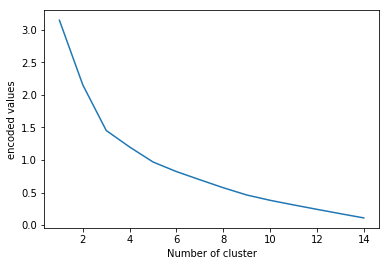

In [35]:
DT_preferences = ['Asian Restaurant','Vegetarian / Vegan Restaurant','Health Food Store','Yoga Studio','Bookstore','Park','Grocery Store','Movie Theater','Café','Gym / Fitness Center']

data = dt_Toronto_grouped[DT_preferences]

data

sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("encoded values")
plt.show()

### In the following code with value of k , k means clustering is used to cluster the data. 

In [36]:

# set number of clusters
kclusters = 3

dtToronto_grouped_clustering = dt_Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans1 = KMeans(n_clusters=kclusters, random_state=0).fit(dtToronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans1.labels_[0:10] 
dtToronto_grouped_clustering.head()

,Asian Restaurant,Bookstore,Café,Grocery Store,Gym / Fitness Center,Health Food Store,Movie Theater,Park,Vegetarian / Vegan Restaurant,Yoga Studio
0,0.181818,0.181818,0.363636,0.000000,0.090909,0.0,0.0,0.000000,0.181818,0.000
1,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.0,0.250000,0.250000,0.000
2,0.000000,0.000000,0.428571,0.142857,0.000000,0.0,0.0,0.428571,0.000000,0.000
3,0.000000,0.125000,0.250000,0.000000,0.250000,0.0,0.0,0.125000,0.125000,0.125
4,0.000000,0.000000,0.416667,0.166667,0.000000,0.0,0.0,0.166667,0.250000,0.000


### In the following code, we add a column called Cluster Labels and generate a data frame with all the relevant data to generate a cluster map. 

In [37]:
final_data = pd.DataFrame()
final_data = neighbourhoods_venues_sorted
# add clustering labels
final_data.insert(0, 'Cluster Labels', kmeans1.labels_)
df_D_Toronto = df_D_Toronto.reset_index(drop=True)
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dToronto_merged = pd.merge(neighbourhoods_venues_sorted, df_D_Toronto, on='Neighbourhood', how='inner')
dToronto_merged.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postcode,Borough,Latitude,Longitude
0,0,Adelaide,Café,Vegetarian / Vegan Restaurant,Bookstore,Asian Restaurant,Gym / Fitness Center,Yoga Studio,Park,Movie Theater,Health Food Store,Grocery Store,M5H,Downtown Toronto,43.650571,-79.384568
1,1,Berczy Park,Café,Vegetarian / Vegan Restaurant,Park,Yoga Studio,Movie Theater,Health Food Store,Gym / Fitness Center,Grocery Store,Bookstore,Asian Restaurant,M5E,Downtown Toronto,43.644771,-79.373306
2,1,Cabbagetown,Park,Café,Grocery Store,Yoga Studio,Vegetarian / Vegan Restaurant,Movie Theater,Health Food Store,Gym / Fitness Center,Bookstore,Asian Restaurant,M4X,Downtown Toronto,43.667967,-79.367675
3,1,Central Bay Street,Gym / Fitness Center,Café,Yoga Studio,Vegetarian / Vegan Restaurant,Park,Bookstore,Movie Theater,Health Food Store,Grocery Store,Asian Restaurant,M5G,Downtown Toronto,43.657952,-79.387383
4,1,Chinatown,Café,Vegetarian / Vegan Restaurant,Park,Grocery Store,Yoga Studio,Movie Theater,Health Food Store,Gym / Fitness Center,Bookstore,Asian Restaurant,M5T,Downtown Toronto,43.653206,-79.400049


### The following code creates a cluster map for data generated using k means clustering 

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dToronto_merged['Latitude'], dToronto_merged['Longitude'], dToronto_merged['Neighbourhood'], dToronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters